In [7]:
# The Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For nicer display in Jupyter
np.set_printoptions(edgeitems=5, linewidth=120)


In [8]:
# Read with pandas (allowed for CSV I/O)
df = pd.read_csv('data/housing.csv')

# Column names for reference only (not used for computation)
columns = df.columns.tolist()
columns


['price',
 'area',
 'bedrooms',
 'bathrooms',
 'stories',
 'mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'parking',
 'prefarea',
 'furnishingstatus']

In [9]:
# Extract relevant columns as NumPy arrays
price = df["price"].to_numpy(dtype=float)
area = df["area"].to_numpy(dtype=float)

# Furnishing status as NumPy string array
furnishing_raw = df["furnishingstatus"].to_numpy().astype(str)

# Clean the text (strip + lowercase) using NumPy string operations
furnishing = np.char.lower(np.char.strip(furnishing_raw))

# Quick sanity checks
print("Unique furnishing [cleaned]:", np.unique(furnishing))
print("Number of observations:", price.shape[0])


Unique furnishing [cleaned]: ['furnished' 'semi-furnished' 'unfurnished']
Number of observations: 545


In [10]:
# In case there were missing values, we can build a validity mask.
# (In this dataset everything is non-missing, but the code is general.)

valid_price = ~np.isnan(price)
valid_area = ~np.isnan(area)

valid_mask = valid_price & valid_area

price = price[valid_mask]
area = area[valid_mask]
furnishing = furnishing[valid_mask]

print("Rows after filtering valid price/area:", price.shape[0])

Rows after filtering valid price/area: 545


In [11]:
# 1) price_per_sqft
price_per_sqft = price / area

# 2) is_premium: 1 if price above the overall mean, else 0
price_mean = np.mean(price)
is_premium = (price > price_mean).astype(int)

print("price_per_sqft (first 5):", price_per_sqft[:5])
print("is_premium (first 20):", is_premium[:20])


price_per_sqft (first 5): [1792.45283019 1367.1875     1229.91967871 1628.66666667 1537.73584906]
is_premium (first 20): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
# ---------- 5.1 Summary stats for price (NumPy) ----------
price_mean = np.mean(price)
price_median = np.median(price)
price_min = np.min(price)
price_max = np.max(price)
price_range = price_max - price_min
price_std = np.std(price, ddof=1)  # sample standard deviation

# Mode via pure NumPy
unique_prices, counts = np.unique(price, return_counts=True)
max_count = counts.max()
modes = unique_prices[counts == max_count]

print("PRICE SUMMARY STATISTICS")
print("------------------------")
print(f"Mean:   {price_mean:,.2f}")
print(f"Median: {price_median:,.2f}")
print("Mode(s):", modes)
print(f"Min:    {price_min:,.2f}")
print(f"Max:    {price_max:,.2f}")
print(f"Range:  {price_range:,.2f}")
print(f"Std:    {price_std:,.2f}")

# ---------- 5.2 Correlation with furnishing status ----------
# Encode furnishing as integer codes: 0, 1, 2
furnishing_levels, furnishing_codes = np.unique(furnishing, return_inverse=True)

corr_matrix = np.corrcoef(price, furnishing_codes)
corr_price_furnish = corr_matrix[0, 1]

print("\nFURNISHING ENCODING")
for idx, label in enumerate(furnishing_levels):
    print(f"Code {idx}: {label}")

print(f"\nCorrelation between price and furnishing_code: {corr_price_furnish:.3f}")


PRICE SUMMARY STATISTICS
------------------------
Mean:   4,766,729.25
Median: 4,340,000.00
Mode(s): [3500000. 4200000.]
Min:    1,750,000.00
Max:    13,300,000.00
Range:  11,550,000.00
Std:    1,870,439.62

FURNISHING ENCODING
Code 0: furnished
Code 1: semi-furnished
Code 2: unfurnished

Correlation between price and furnishing_code: -0.305


In [13]:
price_median = np.median(price)

mask_furnished = furnishing == "furnished"
mask_above_median = price > price_median

mask_furnished_and_expensive = mask_furnished & mask_above_median

filtered_prices = price[mask_furnished_and_expensive]
filtered_price_per_sqft = price_per_sqft[mask_furnished_and_expensive]

print("Number of furnished houses above median price:", filtered_prices.shape[0])
print("First 5 filtered prices:", filtered_prices[:5])
print("First 5 filtered price_per_sqft:", filtered_price_per_sqft[:5])


Number of furnished houses above median price: 87
First 5 filtered prices: [13300000. 12250000. 12215000. 11410000.  9870000.]
First 5 filtered price_per_sqft: [1792.45283019 1367.1875     1628.66666667 1537.73584906 1218.51851852]


/var/folders/bq/rld3dw356d59k6x995889zj00000gn/T/ipykernel_11844/3095767588.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(price_groups, labels=levels)


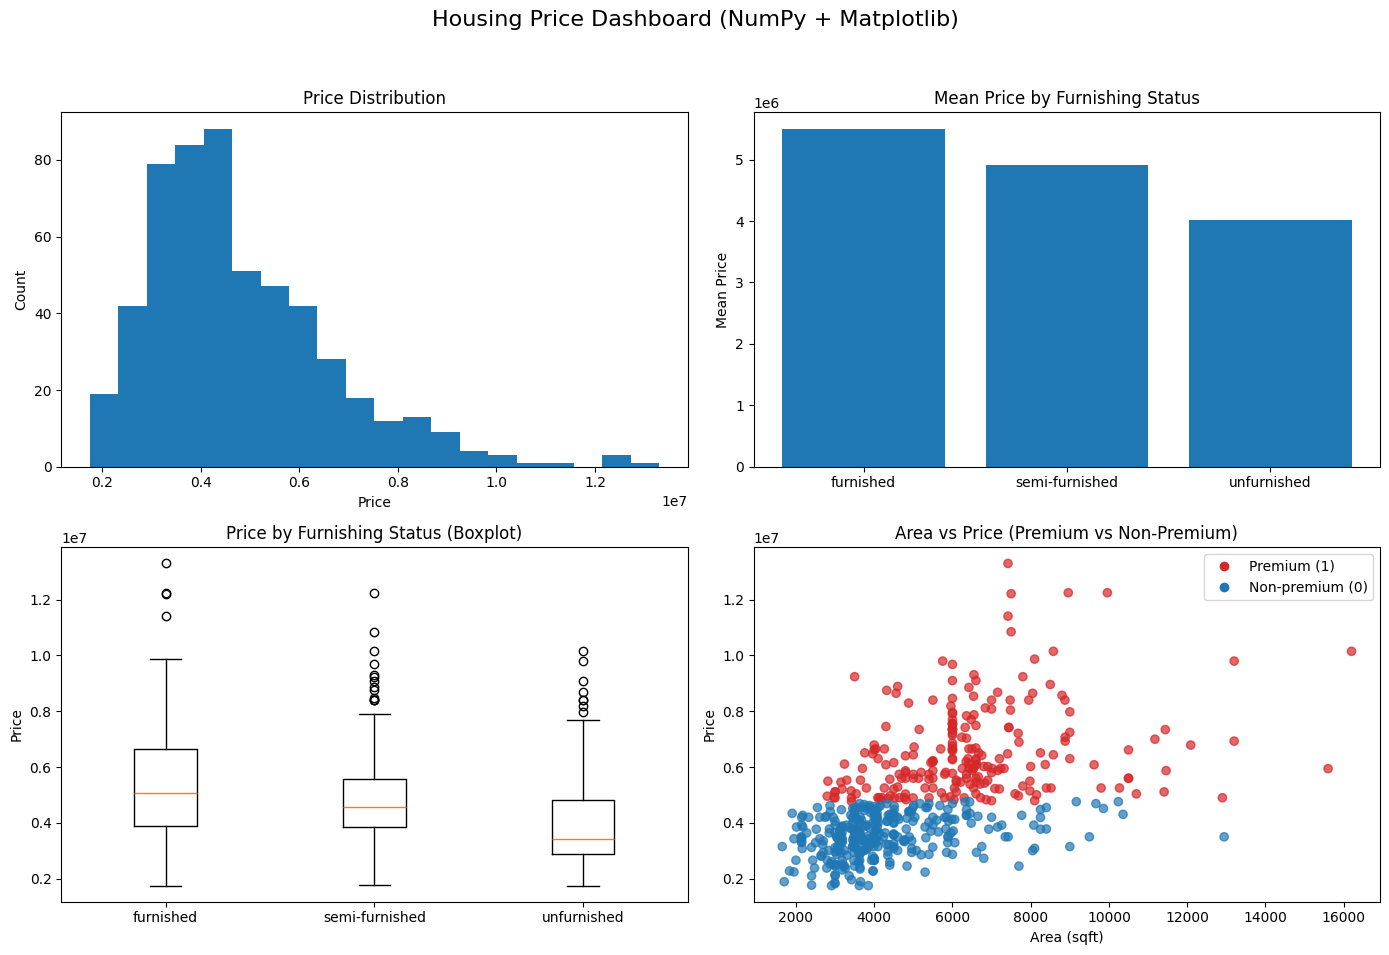

In [14]:
# Precompute grouped data for the plots using NumPy

# Unique furnishing labels and indices
levels, inv = np.unique(furnishing, return_inverse=True)

# Mean price by furnishing status
mean_prices_by_furnish = np.array([price[inv == i].mean() for i in range(len(levels))])

# Price arrays per furnishing category (for boxplot)
price_groups = [price[inv == i] for i in range(len(levels))]

# Scatter helpers: colors by premium flag (just two colors)
premium_colors = np.where(is_premium == 1, "tab:red", "tab:blue")

# ----- DASHBOARD PLOTS -----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Housing Price Dashboard (NumPy + Matplotlib)", fontsize=16)

# 1) Histogram of price
ax = axes[0, 0]
ax.hist(price, bins=20)
ax.set_title("Price Distribution")
ax.set_xlabel("Price")
ax.set_ylabel("Count")

# 2) Mean price by furnishing status (bar chart)
ax = axes[0, 1]
ax.bar(np.arange(len(levels)), mean_prices_by_furnish)
ax.set_title("Mean Price by Furnishing Status")
ax.set_xticks(np.arange(len(levels)))
ax.set_xticklabels(levels)
ax.set_ylabel("Mean Price")

# 3) Boxplot of price by furnishing status
ax = axes[1, 0]
ax.boxplot(price_groups, labels=levels)
ax.set_title("Price by Furnishing Status (Boxplot)")
ax.set_ylabel("Price")

# 4) Scatter: area vs price, colored by premium flag
ax = axes[1, 1]
ax.scatter(area, price, c=premium_colors, alpha=0.7)
ax.set_title("Area vs Price (Premium vs Non-Premium)")
ax.set_xlabel("Area (sqft)")
ax.set_ylabel("Price")
ax.legend(handles=[
    plt.Line2D([0], [0], marker="o", linestyle="", label="Premium (1)", color="tab:red"),
    plt.Line2D([0], [0], marker="o", linestyle="", label="Non-premium (0)", color="tab:blue"),
])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
